In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import math
from IPython.display import display
import seaborn as sns
from scipy.signal import find_peaks
import sys
# add path to the folder containing modeling.py
sys.path.append('/ganram')
import modeling as mdl
import dffuncs as dff
from matplotlib.patches import Ellipse

sns.set()

In [3]:
%load_ext autoreload
%autoreload 2

## Additional functions

In [4]:
def point_in_ellipse(
    p,
    center,
    major,
    minor,
    angle
):
    """Check if the given point lies inside the ellipse specified
    by the given characteristics.
    
    https://stackoverflow.com/questions/7946187/point-and-ellipse-rotated-position-test-algorithm
    """
    cosa = np.cos(np.radians(angle))
    sina = np.sin(np.radians(angle))

    (cen_x, cen_y) = center
    (x, y) = p

    a = (cosa * (x - cen_x) + sina * (y - cen_y))**2 / (major/2)**2
    b = (sina * (x - cen_x) - cosa * (y - cen_y))**2 / (minor/2)**2
    
    ellipse =  a +  b
    
    if ellipse <= 1:
        return True
    else:
        return False

def rotate_point(p, o, degrees):
    """Rotate the coordinates of the point 'p' counterclockwise
    around point 'o' by the specified angle in degrees.
    
    https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
    """
    a = np.radians(degrees)
    ca = np.cos(a)
    sa = np.sin(a)
    rot_mat = np.array([[ca, -sa], [sa, ca]])
    
    p = np.atleast_2d(p)
    o = np.atleast_2d(o)
    
    p_rot = (rot_mat @ (p - o).T + o.T).T
    
    return np.squeeze(p_rot)

def ellipse_nearest(p, center, major, minor, angle):
    """Calculate the distance of the given point from the ellipse with
    the given characteristics.
    """
    p_rot = rotate_point(p, center, degrees=-angle)
    px = abs(p_rot[0] - center[0])
    py = abs(p_rot[1] - center[1])

    tx = 0.707
    ty = 0.707

    a = major / 2
    b = minor / 2

    for _ in range(0, 3):
        x = a * tx
        y = b * ty

        ex = (a*a - b*b) * tx**3 / a
        ey = (b*b - a*a) * ty**3 / b

        rx = x - ex
        ry = y - ey

        qx = px - ex
        qy = py - ey

        r = math.hypot(rx, ry)
        q = math.hypot(qx, qy)

        tx = min(1, max(0, (qx * r / q + ex) / a))
        ty = min(1, max(0, (qy * r / q + ey) / b))
        t = math.hypot(tx, ty)
        tx /= t 
        ty /= t 
        
    p_ell = rotate_point(
        (math.copysign(a * tx, p_rot[0] - center[0]) + center[0],
         math.copysign(b * ty, p_rot[1] - center[1]) + center[1]),
        center,
        angle
    )

    return p_ell

def distance(p1, p2):
    """Calculate the distance between two points.
    """
    return np.linalg.norm(p1 - p2, 2)

def distance_from_ellipse(p, center, major, minor, angle):
    """
    """
    p_ell = ellipse_nearest(p, center, major, minor, angle)
    
    return distance(p, p_ell)

## Working directory

In [5]:
wd = '/ganram/'

# Normal

## Real

In [6]:
real_n = pd.read_csv(
    os.path.join(wd, 'normal.csv'),
    header=0,
    index_col=0,
    sep=';'
).filter(like='Rbhf') #normal bones spectra have a characteristic string in their name
real_n.index = real_n.index.astype(float)
real_n.head()

,11Rbhf_tl-11,11Rbhf_tl-12,11Rbhf_tl-13,11Rbhf_tl-21,11Rbhf_tl-22,11Rbhf_tl-23,11Rbhf_tl-31,11Rbhf_tl-32,11Rbhf_tl-33,11Rbhf_tl-a1,...,6Rbhf_tl-33,6Rbhf_tl-a1,6Rbhf_tl-a2,6Rbhf_tl-a3,6Rbhf_tl-b1,6Rbhf_tl-b2,6Rbhf_tl-b3,6Rbhf_tl-c1,6Rbhf_tl-c2,6Rbhf_tl-c3
Raman_shift,,,,,,,,,,,,,,,,,,,,,
381.095428,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
383.396362,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.697763,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
385.696289,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,11.041691,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
387.995209,0.373425,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,30.218581,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
390.293152,10.331931,0.0,0.0,9.86109,0.0,7.774528,0.0,2.918066,57.530669,11.165919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.468554,0.0,2.433322,0.0


<AxesSubplot:xlabel='Raman_shift'>

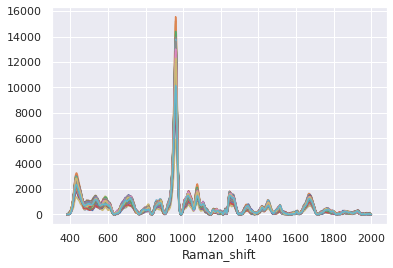

In [7]:
real_n.plot(legend=False)

### Normalize

In [8]:
real_n_norm = dff.norm_peak(
    real_n,
    [955, 965]
)
real_n_norm.head()

,11Rbhf_tl-11,11Rbhf_tl-12,11Rbhf_tl-13,11Rbhf_tl-21,11Rbhf_tl-22,11Rbhf_tl-23,11Rbhf_tl-31,11Rbhf_tl-32,11Rbhf_tl-33,11Rbhf_tl-a1,...,6Rbhf_tl-33,6Rbhf_tl-a1,6Rbhf_tl-a2,6Rbhf_tl-a3,6Rbhf_tl-b1,6Rbhf_tl-b2,6Rbhf_tl-b3,6Rbhf_tl-c1,6Rbhf_tl-c2,6Rbhf_tl-c3
Raman_shift,,,,,,,,,,,,,,,,,,,,,
381.095428,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
383.396362,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000059,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
385.696289,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000929,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
387.995209,0.000048,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.002541,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
390.293152,0.001318,0.0,0.0,0.000935,0.0,0.000609,0.0,0.000218,0.004838,0.000891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000036,0.0,0.000198,0.0


<AxesSubplot:xlabel='Raman_shift'>

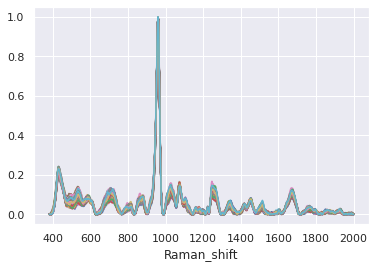

In [9]:
real_n_norm.plot(legend=False)

## Synthetic_raw

In [10]:
synth_n_raw = pd.read_csv(
    os.path.join(wd, 'synthetic.csv'),
    header=0,
    # index_col=0,
)
synth_n_raw.drop(columns=synth_n_raw.columns[0], inplace=True)
synth_n_raw = synth_n_raw.T
synth_n_raw.index.name = 'Raman_shift'
synth_n_raw.index = synth_n_raw.index.astype(float)
synth_n_raw.columns = [f'synth_n_raw_{col + 1}' for col in synth_n_raw.columns]
synth_n_raw.head()

,synth_n_raw_1,synth_n_raw_2,synth_n_raw_3,synth_n_raw_4,synth_n_raw_5,synth_n_raw_6,synth_n_raw_7,synth_n_raw_8,synth_n_raw_9,synth_n_raw_10,...,synth_n_raw_191,synth_n_raw_192,synth_n_raw_193,synth_n_raw_194,synth_n_raw_195,synth_n_raw_196,synth_n_raw_197,synth_n_raw_198,synth_n_raw_199,synth_n_raw_200
Raman_shift,,,,,,,,,,,,,,,,,,,,,
399.474762,501.5681,317.72293,383.44214,505.83185,290.26047,509.33070,480.87630,394.73290,511.02210,324.16852,...,410.55692,480.49197,325.02585,430.64426,535.08330,404.50742,392.42020,308.17728,458.36252,516.01227
401.767670,510.8231,323.57382,383.87976,507.33560,291.30480,511.41860,485.13193,399.46567,515.95557,327.87326,...,410.14438,479.55875,324.92523,430.46260,535.38513,403.88004,391.38670,308.74020,456.60126,514.15155
404.059570,510.1593,323.23474,388.71698,513.12620,293.67890,514.17377,487.64460,398.98715,513.63556,326.11050,...,414.77304,485.68082,329.42830,435.73300,541.10754,409.37585,396.57623,312.22983,462.35547,521.76750
406.350464,509.6870,321.53190,390.60428,512.64874,293.77036,515.07540,488.50528,398.00058,514.25950,326.61060,...,417.06314,487.96880,330.46927,437.92070,543.49270,410.09613,398.13953,313.60187,464.44995,524.66205
408.640350,513.1232,322.08322,392.59894,515.94070,295.86923,519.39465,490.57657,402.03952,518.28370,329.35030,...,420.27908,490.13458,332.96000,440.71765,547.41600,412.42770,400.71774,314.99295,467.37463,527.47190


In [11]:
# get every second column
synth_n_raw = synth_n_raw.iloc[:, ::4]
# synth_n_raw = synth_n_raw.sample(50, axis=1)
synth_n_raw.head()

,synth_n_raw_1,synth_n_raw_5,synth_n_raw_9,synth_n_raw_13,synth_n_raw_17,synth_n_raw_21,synth_n_raw_25,synth_n_raw_29,synth_n_raw_33,synth_n_raw_37,...,synth_n_raw_161,synth_n_raw_165,synth_n_raw_169,synth_n_raw_173,synth_n_raw_177,synth_n_raw_181,synth_n_raw_185,synth_n_raw_189,synth_n_raw_193,synth_n_raw_197
Raman_shift,,,,,,,,,,,,,,,,,,,,,
399.474762,501.5681,290.26047,511.02210,534.52563,569.14905,425.39005,403.60983,518.7403,476.26202,500.66882,...,460.95224,392.58215,565.62994,492.51523,544.41340,333.61930,461.88132,474.42075,325.02585,392.42020
401.767670,510.8231,291.30480,515.95557,545.68774,583.03296,431.66820,405.36267,528.0871,481.67136,504.73334,...,465.41330,400.27472,572.96625,500.08597,545.37775,334.71127,462.59950,474.22650,324.92523,391.38670
404.059570,510.1593,293.67890,513.63556,552.01100,573.89300,429.19336,406.49120,524.5081,489.37265,521.00604,...,456.10147,396.75183,571.42163,498.21542,549.39966,339.24127,468.06323,479.28250,329.42830,396.57623
406.350464,509.6870,293.77036,514.25950,552.02216,570.83310,425.38757,403.71103,523.2103,493.82553,527.80020,...,456.02515,394.31910,570.62150,495.36040,551.51220,340.20750,470.11850,481.01380,330.46927,398.13953
408.640350,513.1232,295.86923,518.28370,547.02970,572.51215,426.36346,402.39148,529.6283,491.03380,522.12980,...,458.41843,399.92215,576.86070,501.60830,557.14660,344.40010,473.41333,485.27985,332.96000,400.71774


<AxesSubplot:xlabel='Raman_shift'>

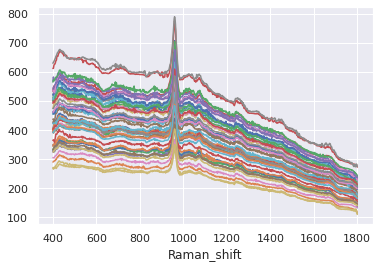

In [12]:
synth_n_raw.plot(legend=False)

### Smooth

<AxesSubplot:xlabel='Raman_shift'>

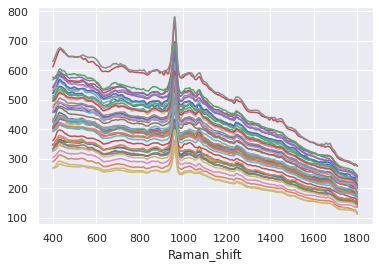

In [13]:
synth_n_raw_smooth = dff.smooth(
    synth_n_raw,
    11,
    2
)

synth_n_raw_smooth.plot(
    legend=False
)

### SNIP

<AxesSubplot:xlabel='Raman_shift'>

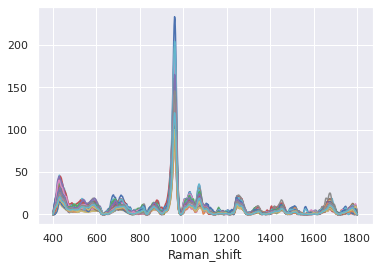

In [14]:
synth_n_raw_snipbg = dff.snip(
    synth_n_raw_smooth,
    15
)
synth_n_raw_snip = synth_n_raw_smooth - synth_n_raw_snipbg

synth_n_raw_snip.plot(
    legend=False
)

### Normalize

<AxesSubplot:xlabel='Raman_shift'>

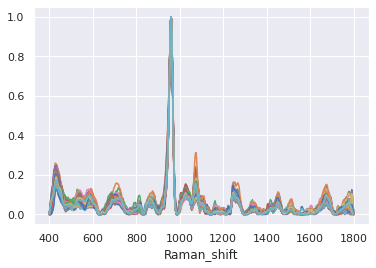

In [15]:
synth_n_raw_norm = dff.norm_peak(
    synth_n_raw_snip,
    [955, 965]
)

synth_n_raw_norm.plot(
    legend=False
)

## PCA real-synthetic_raw

In [16]:
all_n_raw = dff.merge([real_n_norm, synth_n_raw_norm])
all_n_raw.head()

,11Rbhf_tl-11,11Rbhf_tl-12,11Rbhf_tl-13,11Rbhf_tl-21,11Rbhf_tl-22,11Rbhf_tl-23,11Rbhf_tl-31,11Rbhf_tl-32,11Rbhf_tl-33,11Rbhf_tl-a1,...,synth_n_raw_161,synth_n_raw_165,synth_n_raw_169,synth_n_raw_173,synth_n_raw_177,synth_n_raw_181,synth_n_raw_185,synth_n_raw_189,synth_n_raw_193,synth_n_raw_197
Raman_shift,,,,,,,,,,,,,,,,,,,,,
401.767670,0.022023,0.026421,0.016826,0.025837,0.027169,0.020650,0.014909,0.013213,0.027722,0.023858,...,-3.795800e-12,0.005406,0.009643,0.006321,0.016611,0.023539,0.019384,0.016666,0.019108,0.016619
404.059570,0.032339,0.031187,0.026691,0.030809,0.037593,0.025778,0.019032,0.020033,0.033608,0.028173,...,-4.261008e-12,0.012192,0.019519,0.013818,0.032101,0.044460,0.036748,0.032046,0.036443,0.031828
406.350464,0.045208,0.042367,0.039475,0.042316,0.050546,0.037807,0.026077,0.030918,0.042666,0.034883,...,-3.913950e-11,0.020360,0.029626,0.022489,0.046469,0.062764,0.052095,0.046141,0.052006,0.045628
408.640350,0.053346,0.054336,0.050748,0.056677,0.061109,0.049161,0.037332,0.044165,0.057202,0.043220,...,6.563925e-03,0.029908,0.039964,0.032335,0.059716,0.078450,0.065422,0.058949,0.065796,0.058018
410.929230,0.062137,0.069386,0.067270,0.069623,0.071915,0.065797,0.055575,0.058980,0.070040,0.053029,...,2.067934e-02,0.040837,0.050535,0.043357,0.071841,0.091529,0.076731,0.070472,0.077814,0.069186


In [17]:
# all_n_raw_cropped = dff.crop(
#     all_n_raw,
#     start_value=630,
#     stop_value=1800
# )

<AxesSubplot:xlabel='Raman_shift'>

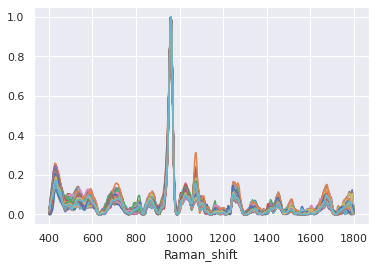

In [18]:
all_n_raw.plot(legend=False)

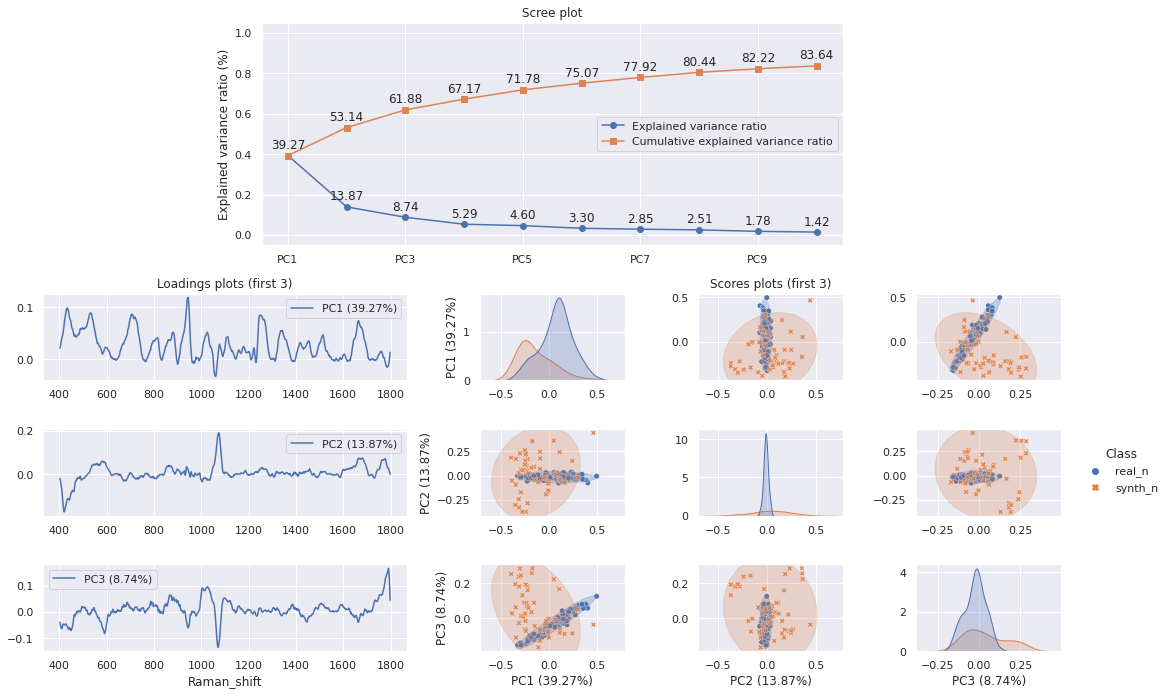

In [19]:
kind = [
    'real_n' if 'Rbhf' in str(col)
    else 'synth_n'
    for col in all_n_raw.columns
]
pca = mdl.PCA(
    all_n_raw.T,
    hue=kind
)

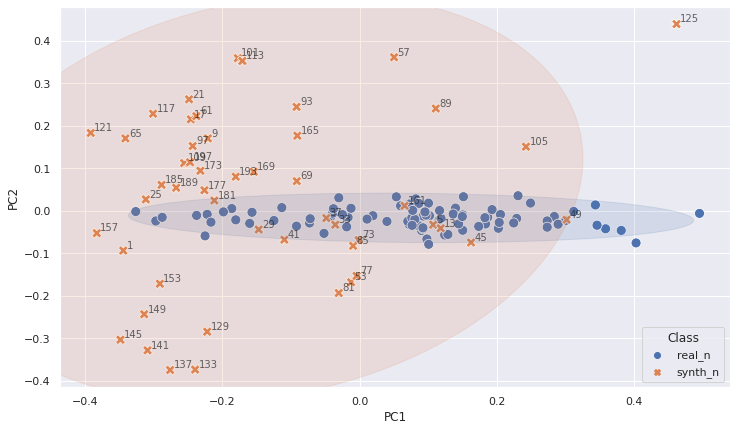

In [20]:
fig, ax = pca.scores_plot(
    figsize=(12, 7),
    markersize=100,
    markers=['o', 'X'],
    # color=['r', 'b', 'r', 'b'],
    ell_alpha=0.15
)

synth_scores = pca.scores_df_[['PC1', 'PC2']].filter(like='synth', axis=0)
for idx in synth_scores.index:
    # m = re.match(r'\w+_(\w+)_\w+_\w+\d+_\w+_\w+\d+_(\w+\d+)_\w+\d+_\d+', idx)
    # name = idx.split('_')[1]
    name = idx.split('_')[-1]
    ax.text(
        x=synth_scores.loc[idx, 'PC1'] + 0.005,
        y=synth_scores.loc[idx, 'PC2'] + 0.005,
        s=name,
        fontsize=10,
        alpha=0.7
    )

# Scavenging PCA

### PCA real-synthetic_raw

In [21]:
all_n_raw = dff.merge([real_n_norm, synth_n_raw_norm])
all_n_raw.head()

,11Rbhf_tl-11,11Rbhf_tl-12,11Rbhf_tl-13,11Rbhf_tl-21,11Rbhf_tl-22,11Rbhf_tl-23,11Rbhf_tl-31,11Rbhf_tl-32,11Rbhf_tl-33,11Rbhf_tl-a1,...,synth_n_raw_161,synth_n_raw_165,synth_n_raw_169,synth_n_raw_173,synth_n_raw_177,synth_n_raw_181,synth_n_raw_185,synth_n_raw_189,synth_n_raw_193,synth_n_raw_197
Raman_shift,,,,,,,,,,,,,,,,,,,,,
401.767670,0.022023,0.026421,0.016826,0.025837,0.027169,0.020650,0.014909,0.013213,0.027722,0.023858,...,-3.795800e-12,0.005406,0.009643,0.006321,0.016611,0.023539,0.019384,0.016666,0.019108,0.016619
404.059570,0.032339,0.031187,0.026691,0.030809,0.037593,0.025778,0.019032,0.020033,0.033608,0.028173,...,-4.261008e-12,0.012192,0.019519,0.013818,0.032101,0.044460,0.036748,0.032046,0.036443,0.031828
406.350464,0.045208,0.042367,0.039475,0.042316,0.050546,0.037807,0.026077,0.030918,0.042666,0.034883,...,-3.913950e-11,0.020360,0.029626,0.022489,0.046469,0.062764,0.052095,0.046141,0.052006,0.045628
408.640350,0.053346,0.054336,0.050748,0.056677,0.061109,0.049161,0.037332,0.044165,0.057202,0.043220,...,6.563925e-03,0.029908,0.039964,0.032335,0.059716,0.078450,0.065422,0.058949,0.065796,0.058018
410.929230,0.062137,0.069386,0.067270,0.069623,0.071915,0.065797,0.055575,0.058980,0.070040,0.053029,...,2.067934e-02,0.040837,0.050535,0.043357,0.071841,0.091529,0.076731,0.070472,0.077814,0.069186


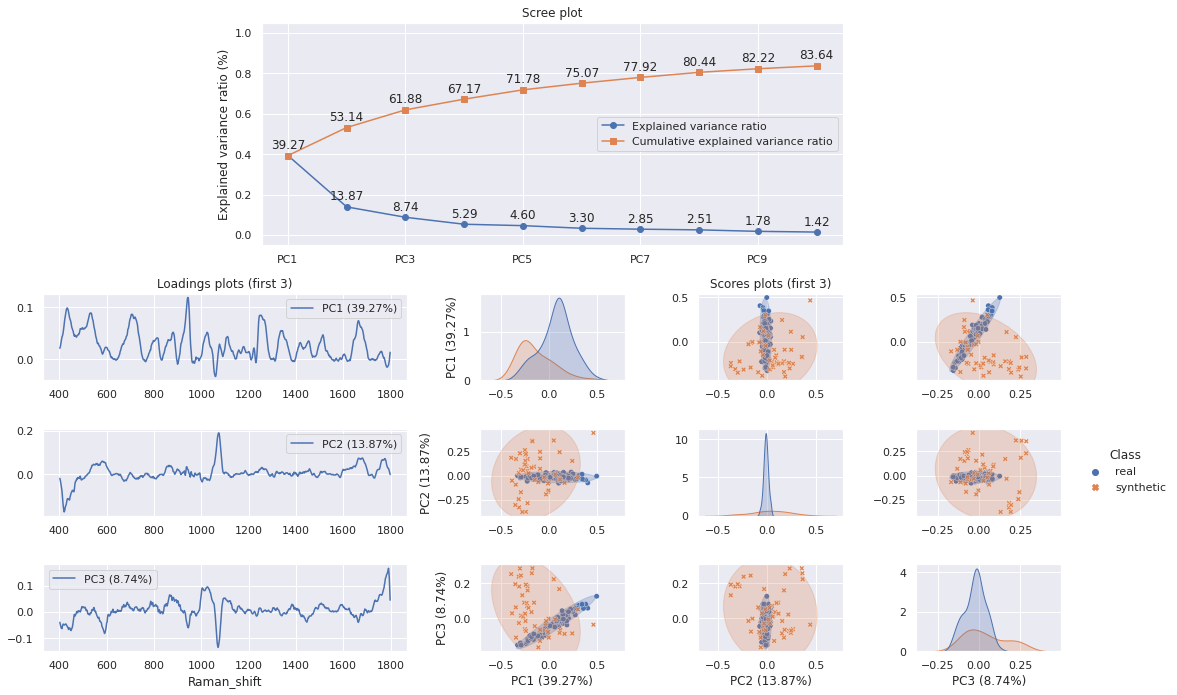

In [22]:
kind = [
    'real' if 'Rbhf' in str(col)
    else 'synthetic'
    for col in all_n_raw.columns
]
pca = mdl.PCA(
    all_n_raw.T,
    hue=kind
)

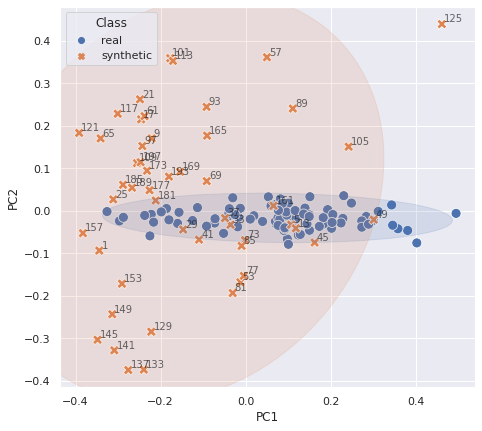

In [23]:
fig, ax = pca.scores_plot(
    figsize=(12, 7),
    markersize=100,
    markers=['o', 'X'],
    # color=['r', 'b', 'r', 'b'],
    ell_alpha=0.15,
    # n_std=2,
    # xlim=[-2, 2],
    # ylim=[-2, 2]
)

synth_scores = pca.scores_df_[['PC1', 'PC2']].filter(like='synth', axis=0)
for idx in synth_scores.index:
    # m = re.match(r'\w+_(\w+)_\w+_\w+\d+_\w+_\w+\d+_(\w+\d+)_\w+\d+_\d+', idx)
    # name = idx.split('_')[1]
    name = idx.split('_')[-1]
    ax.text(
        x=synth_scores.loc[idx, 'PC1'] + 0.005,
        y=synth_scores.loc[idx, 'PC2'] + 0.005,
        s=name,
        fontsize=10,
        alpha=0.7
    )

ax.set_aspect('equal')

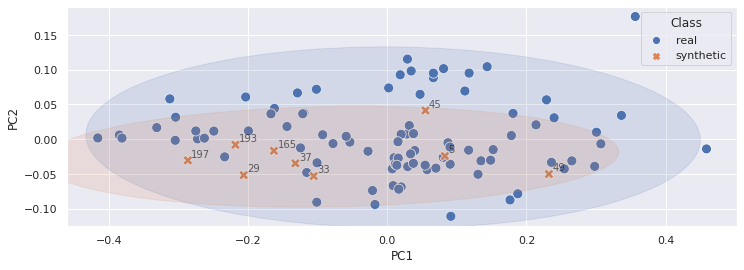

In [24]:
#### real pc1-pc2 scores dataframe
rp = pca.scores_df_[['PC1', 'PC2']].filter(like='Rbhf', axis=0)

while True:
    # real ellipse properties
    center, major, minor, angle = mdl.confidence_ellipse_props(
        x=rp['PC1'],
        y=rp['PC2'],
        conf=0.95
    )
    # synthetic pc1-pc2 scores dataframe
    sp = pca.scores_df_[['PC1', 'PC2']].filter(like='synth', axis=0)

    # create boolean list of synthetic spectra inside the real spectra ellipse
    point_in = []

    for idx in sp.index:
        x = sp.loc[idx, 'PC1']
        y = sp.loc[idx, 'PC2']
        point_in.append(point_in_ellipse((x, y), center, major, minor, angle))

    point_out = np.invert(point_in)

    # dataframe of spectra lying outside the real ellipse
    sp_out = sp[point_out]

    if sp_out.empty:
        break

    # add distance from ellipse to sp_out
    # also remove false positive warning
    pd.options.mode.chained_assignment = None  # default='warn'

    sp_out['distance'] = sp_out.apply(lambda x: distance_from_ellipse(
        (x['PC1'], x['PC2']), center, major, minor, angle), axis=1)

    # get most distant point from ellipse
    most_distant = sp_out['distance'].idxmax(axis=0)

    # remove most distant point from initial dataframe
    all_n_raw.drop(columns=most_distant, inplace=True)

    # PCA
    kind = [
        'real' if 'Rbhf' in str(col)
        else 'synthetic'
        for col in all_n_raw.columns
    ]
    pca = mdl.PCA(
        all_n_raw.T,
        hue=kind,
        summary=False
    )

# PCA plot
fig, ax = pca.scores_plot(
    figsize=(12, 7),
    markersize=100,
    markers=['o', 'X'],
    ell_alpha=0.15,
)

sp_scores = pca.scores_df_[['PC1', 'PC2']].filter(like='synth', axis=0)
for idx in sp_scores.index:
    name = idx.split('_')[-1]
    ax.text(
        x=sp_scores.loc[idx, 'PC1'] + 0.005,
        y=sp_scores.loc[idx, 'PC2'] + 0.005,
        s=name,
        fontsize=10,
        alpha=0.7
    )

ax.set_aspect('equal')

## Paper plots

### PC1-PC2

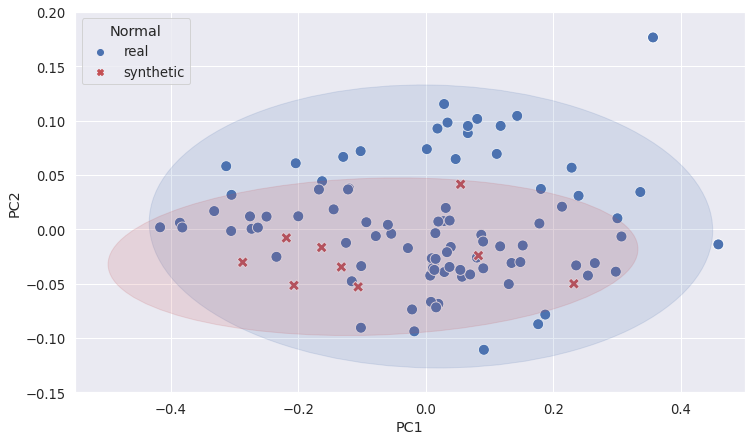

In [25]:
# PCA plot
fig, ax = pca.scores_plot(
    figsize=(12, 7),
    markersize=120,
    markers=['o', 'X'],
    color=['C0', 'C3'],
    ell_alpha=0.15,
    xlim=[-0.55, 0.5],
    ylim=[-0.15, 0.2],
    font_scale=1.2,
    markeredgecolor='w',
    legend_title='Normal'
)
# ax.vlines(0, -0.15, 0.2, color='k', alpha=0.25, linewidth=2, zorder=0.6)
# ax.hlines(0, -0.55, 0.5, color='k', alpha=0.25, linewidth=2, zorder=0.6)

In [27]:
fig.savefig(
    os.path.join(wd, 'paper_plots', 'pc1-pc2_synth-real_normal-paper.png'),
    dpi=400,
    bbox_inches='tight',
    pad_inches=0
)

### Scree plot

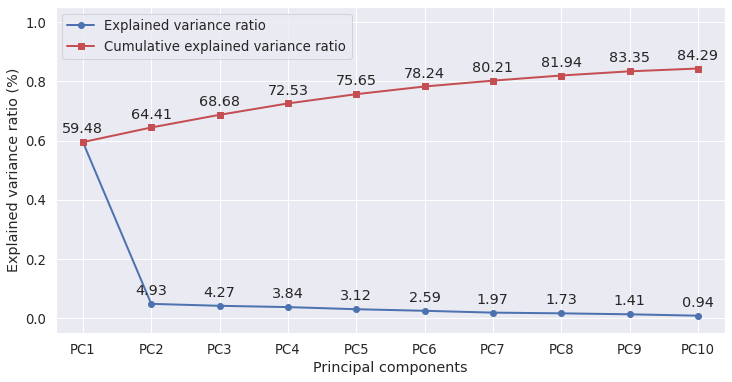

In [480]:
fig, ax = pca.scree_plot(
    figsize=(12, 6),
    font_scale=1.2,
    color=['C0', 'C3'],
    legend_pos='upper left',
    linewidth=2,
    xlim=[-0.4, 9.4]
)
ax.set_xticks([i for i in range(10)])
ax.set_xticklabels([f'PC{i}' for i in range(1, 11)]);
# ax.hlines(0, -0.4, 9.4, color='k', alpha=0.25, linewidth=2, zorder=0.6)

In [481]:
fig.savefig(
    os.path.join(wd, 'paper_plots', 'scree-synth-real_normal-paper.png'),
    dpi=300
)

### Loadings plots

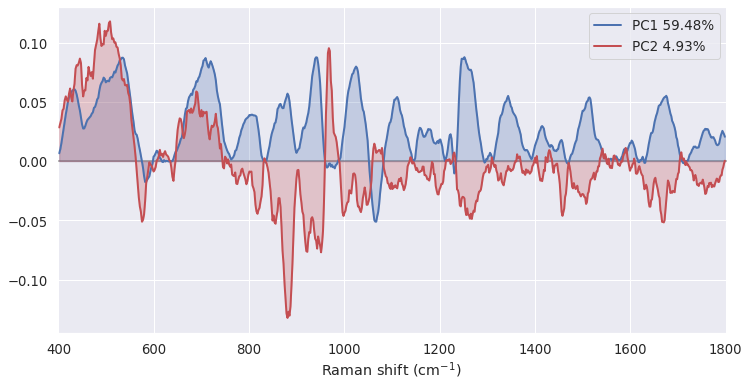

In [497]:
fig, ax = pca.loadings_plot(
    pc=1,
    figsize=(12, 6),
    font_scale=1.2,
    xlim=[397, 1802],
    linewidth=2,
    xlabel='Raman shift (cm$^{-1}$)'
)
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color='k', alpha=0.35, linewidth=2, zorder=0.6)
ax.plot(pca.loadings_df_['PC2'], color='C3', linestyle='-', linewidth=2)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(labels=['aaa', 'bbb'])
labels = [
    f'{pca.variance_df_.columns[0]} {pca.variance_df_.iloc[2, 0]:.2%}',
    f'{pca.variance_df_.columns[1]} {pca.variance_df_.iloc[2, 1]:.2%}'
]
ax.legend(labels, fontsize=13.5)
ax.fill_between(pca.loadings_df_.index, pca.loadings_df_['PC1'], alpha=0.25, color='C0')
ax.fill_between(pca.loadings_df_.index, pca.loadings_df_['PC2'], alpha=0.25, color='C3')

In [498]:
fig.savefig(
    os.path.join(wd, 'paper_plots', 'loadings_1_2-single-synth-real_normal-paper.png'),
    dpi=300
)

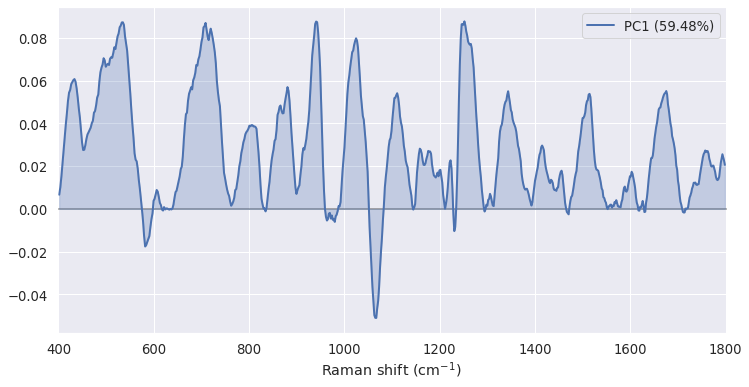

In [499]:
fig, ax = pca.loadings_plot(
    pc=1,
    figsize=(12, 6),
    font_scale=1.2,
    xlim=[397, 1802],
    linewidth=2,
    xlabel='Raman shift (cm$^{-1}$)'
)
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color='k', alpha=0.35, linewidth=2, zorder=0.6)
# ax.plot(pca.loadings_df_['PC2'], color='C3', linestyle='-', linewidth=2)
# # handles, labels = ax.get_legend_handles_labels()
# # ax.legend(labels=['aaa', 'bbb'])
# labels = [
#     f'{pca.variance_df_.columns[0]} {pca.variance_df_.iloc[2, 0]:.2%}',
#     f'{pca.variance_df_.columns[1]} {pca.variance_df_.iloc[2, 1]:.2%}'
# ]
# ax.legend(labels, fontsize=13.5)
ax.fill_between(pca.loadings_df_.index, pca.loadings_df_['PC1'], alpha=0.25, color='C0')
# ax.fill_between(pca.loadings_df_.index, pca.loadings_df_['PC2'], alpha=0.25, color='C3')

In [500]:
fig.savefig(
    os.path.join(wd, 'paper_plots', 'loading_1-synth-real_normal-paper.png'),
    dpi=300
)

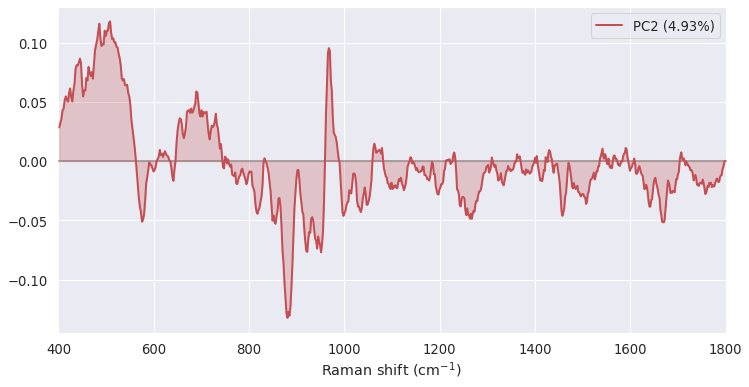

In [501]:
fig, ax = pca.loadings_plot(
    pc=2,
    figsize=(12, 6),
    font_scale=1.2,
    xlim=[397, 1802],
    linewidth=2,
    color='C3',
    xlabel='Raman shift (cm$^{-1}$)'
)
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color='k', alpha=0.35, linewidth=2, zorder=0.6)
# ax.plot(pca.loadings_df_['PC2'], color='C3', linestyle='-', linewidth=2)
# # handles, labels = ax.get_legend_handles_labels()
# # ax.legend(labels=['aaa', 'bbb'])
# labels = [
#     f'{pca.variance_df_.columns[0]} {pca.variance_df_.iloc[2, 0]:.2%}',
#     f'{pca.variance_df_.columns[1]} {pca.variance_df_.iloc[2, 1]:.2%}'
# ]
# ax.legend(labels, fontsize=13.5)
# ax.fill_between(pca.loadings_df_.index, pca.loadings_df_['PC1'], alpha=0.25, color='C0')
ax.fill_between(pca.loadings_df_.index, pca.loadings_df_['PC2'], alpha=0.25, color='C3')

In [502]:
fig.savefig(
    os.path.join(wd, 'paper_plots', 'loading_2-synth-real_normal-paper.png'),
    dpi=300
)

In [488]:
all_n_raw.to_csv(
    os.path.join(wd, 'synth_real-normal-after_cleaning.csv'),
    sep=';'
)